# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas.

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. _Make sure to answer every question marked with a `Q:` for full credit._


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
from pathlib import Path

In [3]:
# change `data_location` to the location of the folder on your machine.
# data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"
data_location = Path("./datasets")

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens,
    number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity),
    and num_tokens most common tokens. Return a list with the number of tokens, number
    of unique tokens, lexical diversity, and number of characters.

    """

    def count_char_of_token(token_list):
        total = 0
        for token in token_list:
            total += len(token)

        return total

    def lex_diversity(unique, total):
        lex_div = 0
        if total > 0:
            lex_div = unique / total

        return lex_div

    # Fill in the correct values here.
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = lex_diversity(num_unique_tokens, num_tokens)
    num_characters = count_char_of_token(tokens)

    most_common_tokens = Counter(tokens).most_common(5)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        print(most_common_tokens)

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert descriptive_stats(text, verbose=True)[0] == 13
assert descriptive_stats(text, verbose=False)[1] == 9
assert abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02
assert descriptive_stats(text, verbose=False)[3] == 55

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
[('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code?

A: Assertion statements are typically used in unit testing. This allows the developer to ensure the code is returning the expected values by creating assert statements that given a specific input, this is what I am expecting this function to provide.


## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.


In [6]:
# Read in the lyrics data

# create path to lyrics
lyrics_path = os.path.join(data_location, lyrics_folder)

# get list of artists in lyrics folder
artists = os.listdir(lyrics_path)

# initialize rows list for dataframe
rows = []

for artist in artists:
    # create path to song lyrics
    song_lyrics_path = os.path.join(lyrics_path, artist)

    # iterate through all song files in the directory
    for songs in os.listdir(song_lyrics_path):
        # create path to song file
        file_path = os.path.join(song_lyrics_path, songs)

        # read txt file to lyrics var
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        # create regex to capture title between double quotes
        match = re.match(r'^"(.*)"$', lines[0].strip())
        if match:
            song_title = match.group(1)
        else:
            # fallback to first line as title
            song_title = lines[0].strip()

        # save rest of lines to lyrics
        lyrics = "".join(lines[1:]).strip()

        rows.append({"artist": artist, "song_title": song_title, "lyrics": lyrics})

# create dataframe from rows var
df_lyrics = pd.DataFrame(rows)

In [7]:
# Read in the twitter data

twitter_path = os.path.join(data_location, twitter_folder)

twitter_files = os.listdir(twitter_path)

rows = []

# Regex101 was used to create the regex
# ChatGPT was used to help create the syntax to make the regex useable with
# Python
LINE_RE = re.compile(
    r"^(?P<screen_name>[^\t]*)\t"
    r"(?P<name>[^\t]*)\t"
    r"(?P<id>\d+)\t"
    r"(?P<location>[^\t]*)\t"
    r"(?P<followers_count>\d+)\t"
    r"(?P<friends_count>\d+)\t"
    r"(?P<description>.*)$"
)


for file in twitter_files:
    # filter for data file that has description column
    if "_data.txt" in file and file != ".DS_Store":
        # save robynkonichiwa as robyn
        artist = file.split("_")[0].replace("konichiwa", "")
        file_path = os.path.join(twitter_path, file)

        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            # skip header row by assigning to `_`
            _ = f.readline()
            # iterate through remaining lines
            for line in f:
                line = line.rstrip("\n")
                m = LINE_RE.match(line)
                if m:
                    desc = m.group("description")
                    # only append if desc is not blank
                    if desc:
                        rows.append({"artist": artist, "description": desc})


df_twitter = pd.DataFrame(rows)

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame.


In [ ]:
# removed # from punctuation set to keep hashtags
punctuation = set(punctuation) - {"#"}  # speeds up comparison


def remove_punctuation(text):
    sentence = ""
    for ch in text:
        if ch not in punctuation:
            sentence += ch
    return sentence


def remove_stopwords(tokens):
    tkn = []
    for token in tokens:
        if token not in sw:
            tkn.append(token)
    return tkn


def clean_text(text):
    # remove punctuation
    text = remove_punctuation(text)
    # make lowercase
    text = text.lower()
    # tokenize by splitting by whitespace
    tokens = text.split()

    return tokens

In [9]:
# create your clean twitter data here
twitter_pkl = data_location / "df_twitter_cleaned.pkl"
if not twitter_pkl.exists():
    print("Cleaning and saving data...")
    df_twitter["description"] = df_twitter["description"].apply(clean_text)
    df_twitter["no_sw"] = df_twitter["description"].apply(remove_stopwords)

    # save cleaned DF to pickle
    df_twitter.to_pickle(twitter_pkl)

else:
    print("Dataframe already exists! Loading...")
    df_twitter = pd.read_pickle(twitter_pkl)

Cleaning and saving data...


In [10]:
# create your clean lyrics data here
lyrics_pkl = data_location / "df_lyrics_cleaned.pkl"
if not lyrics_pkl.exists():
    print("Cleaning and saving data... ")
    df_lyrics["lyrics"] = df_lyrics["lyrics"].apply(clean_text)
    df_lyrics["no_sw"] = df_lyrics["lyrics"].apply(remove_stopwords)

    # save cleaned DF to pickle
    df_lyrics.to_pickle(lyrics_pkl)

else:
    print("Dataframe already exists! Loading...")
    df_lyrics = pd.read_pickle(lyrics_pkl)

Cleaning and saving data... 


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls).


In [11]:
# calls to descriptive_stats here
def get_token_list(dataframe, artist_name, column):
    token_list = []
    artist_rows = dataframe[dataframe["artist"] == artist_name]
    lists = artist_rows[column].tolist()
    for list in lists:
        token_list.extend(list)
    return token_list


# lyrics
cher_lyrics = get_token_list(df_lyrics, "cher", "no_sw")
robyn_lyrics = get_token_list(df_lyrics, "robyn", "no_sw")

print("\nDescriptive Stats Cher Lyrics:\n")
descriptive_stats(cher_lyrics)
print("\nDescriptive Stats Robyn Lyrics:\n")
descriptive_stats(robyn_lyrics)

# twitter
cher_twitter = get_token_list(df_twitter, "cher", "no_sw")
robyn_twitter = get_token_list(df_twitter, "robyn", "no_sw")

print("\nDescriptive Stats Cher Twitter:\n")
descriptive_stats(cher_twitter)
print("\nDescriptive Stats Robyn Twitter:\n")
descriptive_stats(robyn_twitter)


Descriptive Stats Cher Lyrics:

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
[('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]

Descriptive Stats Robyn Lyrics:

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
[('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]

Descriptive Stats Cher Twitter:

There are 15674013 tokens in the data.
There are 1555373 unique tokens in the data.
There are 93389697 characters in the data.
The lexical diversity is 0.099 in the data.
[('love', 213522), ('im', 139051), ('life', 122680), ('music', 86733), ('de', 72970)]

Descriptive Stats Robyn Twitter:

There are 1495780 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158569 characters in the data.
The lexica

[1495780, 258391, 0.17274666060516922, 9158569]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data?

A: It would be different because the top 5 words would be comprised of the stopwords.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs?

A: Honestly, I didn't have any beliefs about lexical diversity between the artists. Looking at the statistical data for lyrics, Cher has a lower lexical diversity compared to Robyn, but Cher also has twice as many words (tokens) in the dataset compared to Robyn which would lead to a lower lexical diversity. The Twitter data are tweets from their fan base and have about an equal amount of tokens making for a better comparison. Robyn has a higher lexical diversity compared to Cher for tweets showing that Europeans might have a better grasp of utilizing all aspects of the English language. On the other hand, the higher lexical diversity for Robyn could also represent the diversity of English language used from different countries.


## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist.
1. For each artist, a histogram of song lengths (in terms of number of tokens)

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [12]:
assert emoji.is_emoji("❤️")
assert not emoji.is_emoji(":-)")

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions?


In [ ]:
# Your code here
def get_emojis(list):
    emoji_list = []
    for l in list:
        if emoji.is_emoji(l):
            emoji_list.append(l)
    return emoji_list


cher_emojis = get_emojis(cher_twitter)
robyn_emojis = get_emojis(robyn_twitter)

print("Cher's 10 most common emojis in Twitter descriptions are:\n")
print(Counter(cher_emojis).most_common(10))

print("\n\nRobyn's 10 most common emojis in Twitter descriptions are:\n")
print(Counter(robyn_emojis).most_common(10))

Cher's 10 most common emojis in Twitter desriptions are:

[('❤️', 14715), ('🏳️\u200d🌈', 14122), ('♥', 10154), ('❤', 9651), ('✨', 8343), ('🌈', 5474), ('🇺🇸', 3696), ('💙', 3684), ('💜', 3499), ('🌊', 3278)]


Robyn's 10 most common emojis in Twitter desriptions are:

[('🏳️\u200d🌈', 1701), ('♥', 1167), ('❤️', 987), ('✨', 751), ('❤', 653), ('🌈', 570), ('🎶', 272), ('🎧', 213), ('🖤', 212), ('💜', 205)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions?


In [24]:
type(cher_twitter)
cher_twitter

['𝙿𝚛𝚘𝚞𝚍',
 '𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛',
 '𝚘𝚏',
 '𝚖𝚎𝚜𝚜𝚢',
 '𝚋𝚞𝚗𝚜',
 '𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜',
 '163㎝／愛かっぷ💜26歳🍒',
 '工〇好きな女の子💓',
 'フォローしてくれたらdmします🧡',
 'csu',
 'writer',
 'washinformer',
 'spelmancollege',
 'alumna',
 '#dcnative',
 'awardwinning',
 'journalist',
 'pr',
 'pro',
 'iabc',
 'fellow',
 'past',
 'chair',
 'ig',
 'bcscomm',
 'email',
 'wibsilergmailcom',
 'i’m',
 'unemployed',
 'live',
 'parents',
 'moops',
 'zoowee',
 'mama',
 'let',
 'healing',
 'begin',
 'let',
 'us',
 'learn',
 'past',
 '🇨🇦',
 'follower',
 '#theresistance',
 'thou',
 'wilt',
 '🖤✨',
 'curious',
 'canadian',
 'contemplator',
 'sheher',
 'sexagenarian',
 'sheherhers',
 'feminist',
 'lgbtq',
 'blm',
 'mental',
 'health',
 'advocate',
 'something',
 'nice',
 'somebody',
 'today',
 'ig',
 'browsbyluz',
 'blm',
 'love',
 '80s',
 'viva',
 'méxico',
 'ubuntu',
 'mudita',
 '🧩',
 'infp🌻',
 'im',
 'guy',
 'married',
 'kids',
 'constantly',
 'wonder',
 'happened',
 'life',
 'expect',
 'understand',
 'oh',
 'yeah',
 'follow',
 'okay',
 'dance',
 'clean

In [ ]:
# Your code here
def get_hashtags(list):
    hashtags = []
    for item in list:
        hashtag = re.findall(r"#\w+", item)
        hashtags.extend(hashtag)
    return hashtags
    # return re.findall(r"#\w+", list)


cher_hashtags = get_hashtags(cher_twitter)
robyn_hashtags = get_hashtags(robyn_twitter)

print("Cher's 10 most common hashtags in Twitter descriptions are:\n")
print(Counter(cher_hashtags).most_common(10))

print("\n\nRobyn's 10 most common hashtags in Twitter descriptions are:\n")
print(Counter(robyn_hashtags).most_common(10))

Cher's 10 most common hashtags in Twitter desriptions are:

[('#resist', 11593), ('#blm', 10423), ('#blacklivesmatter', 8151), ('#theresistance', 3500), ('#fbr', 3403), ('#resistance', 3039), ('#1', 2577), ('#voteblue', 2300), ('#lgbtq', 2032), ('#bidenharris', 1679)]


Robyn's 10 most common hashtags in Twitter desriptions are:

[('#blacklivesmatter', 602), ('#blm', 360), ('#music', 306), ('#1', 198), ('#teamfollowback', 134), ('#edm', 111), ('#lgbtq', 88), ('#resist', 85), ('#art', 72), ('#love', 72)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [ ]:
# Your code here


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out.


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

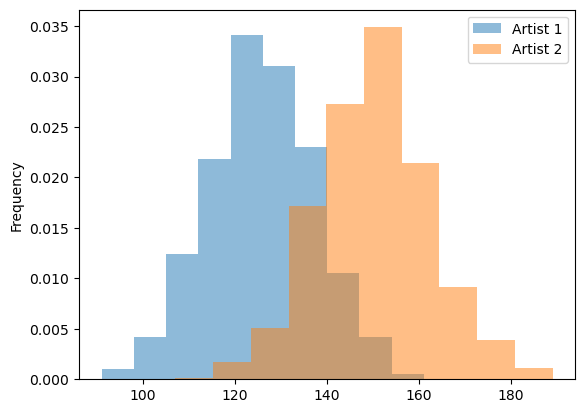

In [16]:
num_replicates = 1000

df = pd.DataFrame(
    {
        "artist": ["Artist 1"] * num_replicates + ["Artist 2"] * num_replicates,
        "length": np.concatenate(
            (
                np.random.poisson(125, num_replicates),
                np.random.poisson(150, num_replicates),
            )
        ),
    }
)

df.groupby("artist")["length"].plot(kind="hist", density=True, alpha=0.5, legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting.

Q: What does the regular expression `'\s+'` match on?

A:


In [17]:
collapse_whitespace = re.compile(r"\s+")


def tokenize_lyrics(lyric):
    """strip and split on whitespace"""
    return [item.lower() for item in collapse_whitespace.split(lyric)]

In [18]:
# Your lyric length comparison chart here.